# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
nltk.download('stopwords') 
from nltk.corpus import stopwords
import pandas as pd
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql_table("cleaned_data",engine)

# Look at data initial values
display(df.head())
print("Shape of data : ",df.shape)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Shape of data :  (26215, 40)


In [4]:
#Seperating input and output

#input
X = df["message"]
display(X.head())

#output
Y = df.iloc[:,4:]
display(Y.head())

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#category names
category_names = Y.columns
category_names

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [6]:
# getting percentage of messages per category 
catergory_columns_data = df.iloc[:,4:]
total_messages = catergory_columns_data.shape[0]
messages_per_category = catergory_columns_data.sum().sort_values(ascending = False)
percent_messages_per_catergory = ((messages_per_category/total_messages)*100)
catergory_names = list(percent_messages_per_catergory.index)
percentage_values = list(percent_messages_per_catergory)
percentage_values

[76.64695784855998,
 41.42666412359336,
 27.8352088498951,
 19.359145527369826,
 17.0665649437345,
 13.145145908830822,
 11.150104901773794,
 9.364867442304025,
 9.31909212283044,
 8.827007438489415,
 8.22048445546443,
 7.949647148579057,
 6.503909975205035,
 6.37802784665268,
 5.248903299637612,
 5.084875071523936,
 5.008582872401297,
 4.5813465573145145,
 4.55464428762159,
 4.390616059507916,
 3.337783711615487,
 3.2805645622735073,
 2.7617776082395578,
 2.3040244135037193,
 2.029372496662216,
 2.021743276749952,
 1.7966812893381652,
 1.544917032233454,
 1.1787144764447837,
 1.1367537669273315,
 1.0795346175853517,
 1.07572000762922,
 0.6065229830249856,
 0.4577531947358383,
 0.4501239748235743,
 0.0]

Total Number of Messages: 26215


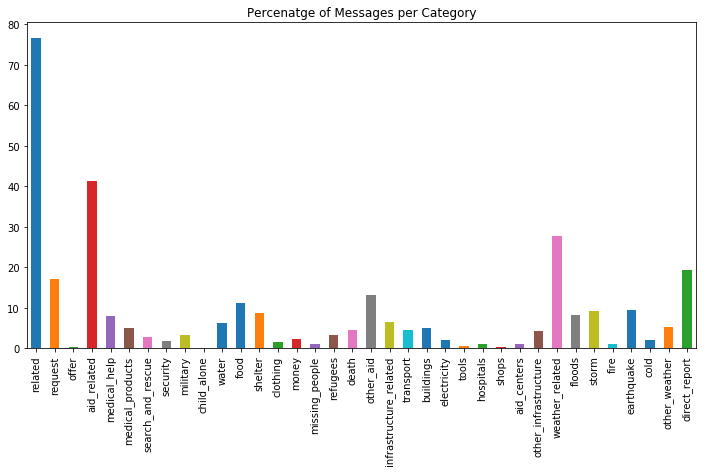

In [8]:
#total number of Messages
print("Total Number of Messages:",Y.shape[0])

#plot of fraction of messages among each categories
((Y.sum()/Y.shape[0])*100).plot(kind="bar",
                          title = "Percenatge of Messages per Category", 
                          figsize = (12,6))

#Observation from Bar plot : For many categories, there is a clear imbalance 
#of data and therefore accuray will not be a good metric for performace evaluation. 

In [11]:
# Percentage of messages with no labels from all categories
percent_no_category = (sum(Y.sum(axis=1)==0)/Y.shape[0])*100
print("Percentage of messages with no labels :",percent_no_category)

Percentage of messages with no labels : 23.353042151440015


In [12]:
def tokenize(text):
    text = text.lower() # lower the capital case
    text = re.sub(r"[^a-zA-Z0-9]"," ",text)#remove punctuation symbols
    words = word_tokenize(text)# tokenize into words
    
    # lemmantize the words and remove stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    words_lem = [lemmatizer.lemmatize(word) 
                 for word in words if word not in stop_words]
    return words_lem

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [13]:
pipeline = Pipeline([
    ("vect",CountVectorizer(tokenizer = tokenize)),
    ("TfidfVect",TfidfTransformer()),
    ("clf", MultiOutputClassifier(DecisionTreeClassifier(random_state=42)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [15]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
#number of examples in Train data
print("Number of examples in Train data:",y_train.shape[0])

#number of examples in Test data
print("Number of examples in Test data:",y_test.shape[0])

Number of examples in Train data: 20972
Number of examples in Test data: 5243


In [17]:
#fit pipeline
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [18]:
#looking at predictions
predicted = pipeline.predict(X_test)
print(predicted)

[[1 1 0 ..., 0 0 1]
 [1 0 0 ..., 1 0 0]
 [1 0 0 ..., 0 0 1]
 ..., 
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [19]:
# looking at f1 score, precision and recall for each output category
for i in range(0,category_names.size):
    target_names = [category_names[i]]
    print(classification_report(y_test.iloc[:,i].values, predicted[:,i], target_names=target_names))

             precision    recall  f1-score   support

    related       0.52      0.52      0.52      1245

avg / total       0.77      0.77      0.77      5243

             precision    recall  f1-score   support

    request       0.90      0.92      0.91      4352

avg / total       0.85      0.85      0.85      5243

             precision    recall  f1-score   support

      offer       1.00      1.00      1.00      5219

avg / total       0.99      0.99      0.99      5243

             precision    recall  f1-score   support

aid_related       0.75      0.76      0.75      3079

avg / total       0.71      0.71      0.71      5243

              precision    recall  f1-score   support

medical_help       0.94      0.95      0.95      4808

 avg / total       0.89      0.90      0.90      5243

                  precision    recall  f1-score   support

medical_products       0.96      0.98      0.97      4964

     avg / total       0.94      0.94      0.94      5243

          

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 1
  .format(len(labels), len(target_names))


### 6. Improve your model
Use grid search to find better parameters. 

In [38]:
import sklearn
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import warnings
#import sklearn.exception
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

parameters = {'clf__estimator__max_depth': [10,20]}

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1_score': make_scorer(f1_score, average = 'macro')}

#warnings.filterwarnings("ignore",category=sklearn.exceptions.UndefinedMetricWarning)

# create grid search object and return as final model pipeline
CV = GridSearchCV(estimator = pipeline,scoring = scoring ,
                  param_grid = parameters,refit ="f1_score"
                  ,cv=3,return_train_score=True,verbose =1)

# train model
CV.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
           n_jobs=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__max_depth': [10, 20]},
       pre_dispatch='2*n_jobs', refit='f1_score', return_train_score=True,
       scoring={'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score, average=macro), 'recall': make_scorer(recall_score, average=macro), 'f1_score': make_scorer(f1_score, average=macro)},
       verbose=1)

In [39]:
# look at grid search results
results = CV.cv_results_
display(pd.DataFrame(results))

print("Best Parameters:", CV.best_params_)
print("Best Score:", CV.best_score_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator__max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,...,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,mean_train_f1_score,std_train_f1_score
0,21.819127,0.057069,18.889561,0.175853,10,{'clf__estimator__max_depth': 10},0.214562,0.224574,0.225465,0.221533,...,0.395983,0.399093,0.396944,0.001522,2,0.592235,0.579506,0.592565,0.588102,0.006080
1,34.745797,0.726215,18.847438,0.142256,20,{'clf__estimator__max_depth': 20},0.216993,0.216993,0.216166,0.216718,...,0.408936,0.402726,0.403057,0.004671,1,0.718737,0.716647,0.718082,0.717822,0.000872


Best Parameters: {'clf__estimator__max_depth': 20}
Best Score: 0.403057493521


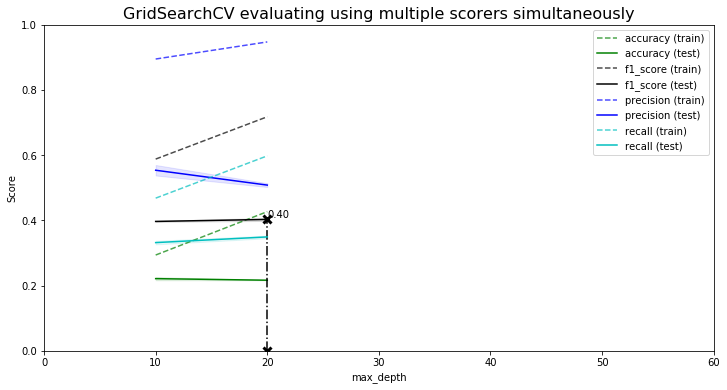

In [40]:
#Plotting the model metrics during cross validation
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("max_depth")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 60)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_clf__estimator__max_depth"].data,dtype=float) # need to check

for scorer, color in zip(sorted(scoring), ['g', 'k','b','c']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    if scorer == 'f1_score':
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
        
        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [41]:
# looking at predictions
y_pred = CV.predict(X_test)
y_pred[0:5]

array([[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [42]:
for i in range(0,category_names.size):
    target_names = [category_names[i]]
    print(classification_report(y_test.iloc[:,i].values, y_pred[:,i], target_names=target_names))

             precision    recall  f1-score   support

    related       0.61      0.21      0.31      1245

avg / total       0.75      0.78      0.74      5243

             precision    recall  f1-score   support

    request       0.90      0.96      0.93      4352

avg / total       0.87      0.88      0.87      5243

             precision    recall  f1-score   support

      offer       1.00      1.00      1.00      5219

avg / total       0.99      1.00      0.99      5243

             precision    recall  f1-score   support

aid_related       0.73      0.87      0.79      3079

avg / total       0.73      0.73      0.72      5243

              precision    recall  f1-score   support

medical_help       0.94      0.98      0.96      4808

 avg / total       0.90      0.92      0.91      5243

                  precision    recall  f1-score   support

medical_products       0.96      0.99      0.97      4964

     avg / total       0.94      0.95      0.94      5243

          

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 1
  .format(len(labels), len(target_names))


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [43]:
def save_model(model, model_filepath):
    pkl_filename = model_filepath
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
save_model(CV,"model.pkl")